In [1]:
import tensorflow as tf
import pandas as pd

from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import cv2
import numpy as np

#albumentations

In [2]:
import matplotlib.pyplot as plt
import os
import PIL
from PIL import Image

In [3]:
tory = '/Users/vishva/Desktop/Manga-Faces-dataset/'

In [4]:
import glob
paths = glob.glob(os.path.join(tory, '*'))

In [5]:
os.listdir(tory)

['happy',
 'sad',
 'crying',
 'pleased',
 'angry',
 'embarrassed',
 'pout',
 'normal',
 'shock',
 'blushed',
 'confused']

In [6]:
import pathlib
tpath = pathlib.Path(tory)
imgnum = len(list(tpath.glob('*/*')))
print(imgnum)

670


In [7]:
emotions = ['happy',
 'sad',
 'crying',
 'pleased',
 'angry',
 'embarrassed',
 'pout',
 'normal',
 'shock',
 'blushed',
 'confused']

In [8]:
nums = 0
for i in emotions:
    nums+=1
print(nums)

11


In [9]:
emot = 'happy'
happy = list(tpath.glob(f' {emot} /*'))

In [10]:
happy = list(tpath.glob('happy'))

In [11]:
batch_size = 30
img_height = 256
img_width = 256
seed = 64

In [12]:
trainData = tf.keras.utils.image_dataset_from_directory(
    directory = tory,
    #labels=,
    label_mode='int',
    #class_names=,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed = seed ,
    validation_split=.15,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 509 files belonging to 11 classes.
Using 433 files for training.


2022-08-31 17:28:55.312353: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
valData = tf.keras.utils.image_dataset_from_directory(
    directory = tory,
    #labels=,
    label_mode='int',
    #class_names=,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed = seed ,
    validation_split=.15,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 509 files belonging to 11 classes.
Using 76 files for validation.


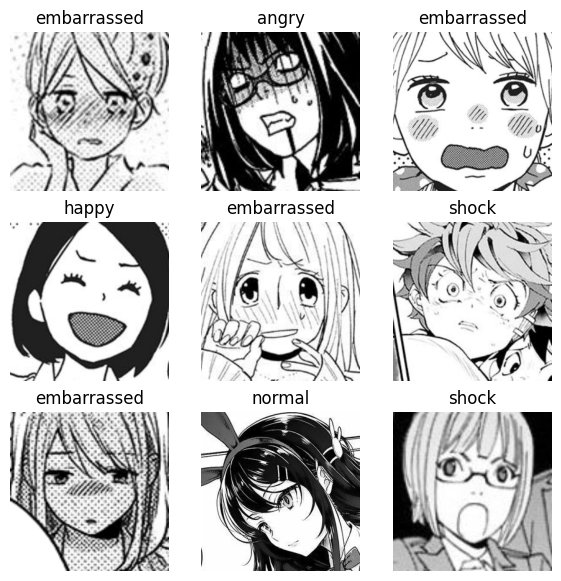

In [14]:
plt.figure(figsize=(7, 7))
for img, lbl in trainData.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i].numpy().astype("uint8"), cmap = 'gray')
    plt.title((trainData.class_names)[lbl[i]])
    plt.axis("off")

In [15]:
trainData = trainData.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valData = trainData.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalize = trainData.map(lambda x, y: (normalization_layer(x), y))
image, label = next(iter(normalize))

In [18]:
first_image = image[0]

In [19]:
import numpy as np
print(np.min(first_image), np.max(first_image))

5.8342433e-05 1.0


In [20]:
import efficientnet.keras as efn

In [21]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights= None,
    input_tensor=None,
    input_shape=(img_height, img_width, 1),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [22]:
base_model.trainable = False

In [23]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(11, activation="softmax")
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4048991   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 1280)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 11)                225291    
                                                                 
Total params: 4,274,282
Trainable params: 225,291
Non-trainable params: 4,048,991
_________________________________________________________________


In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
   loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False,label_smoothing=0.0, axis=-1, reduction="auto",name="categorical_crossentropy"), 
   metrics = tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None), 
   jit_compile = True
)

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
    run_eagerly=True
)

In [27]:
len(trainData)

15

In [28]:
model.fit(
    trainData,
    epochs=13,
    validation_data=valData,
)

Epoch 1/13


/Users/vishva/Desktop/MangaFace/venv/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


15/15 [==============================] - 154s 10s/step - loss: 2.3943 - accuracy: 0.1940 - val_loss: 2.3900 - val_accuracy: 0.1986
Epoch 2/13
 1/15 [=>............................] - ETA: 1:59 - loss: 2.3880 - accuracy: 0.2667

KeyboardInterrupt: 